In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

We will limit our data to the country **USA**:

In [191]:
def dataframeByRegion(df, region):
    return df[df['region'] == region]

In [192]:
spotify_data = pd.read_csv("../data/spotify_2020+_cleaned.csv")
spotify_data["date"] = pd.to_datetime(spotify_data["date"])
us_data = dataframeByRegion(spotify_data, "United States")
us_data.dtypes

Unnamed: 0             int64
title                 object
rank                   int64
date          datetime64[ns]
artist                object
region                object
chart                 object
trend                 object
dtype: object

first, lets check if a song title is aviable both in **top200** and **viral50** charts:

In [193]:
def find_valid_songs(my_data): # returns a list of songs which appear both in top200 and viral50 charts
    data_by_title = my_data.groupby("title")
    usable_titles = []
    for (name,group) in data_by_title.__iter__():
        if ("viral50" in group["chart"].unique() ) and ("top200" in group["chart"].unique()):
            usable_titles.append(name)
    usable_titles = pd.Series(usable_titles)
    num_title = len(us_data["title"].unique())
    print(f" titles which appear in both charts: {usable_titles.count()}\n total number of titles: {num_title}")
    return usable_titles


In [194]:
usable_titles = find_valid_songs(us_data)
usable_title_df = us_data[us_data["title"].isin(usable_titles)]
usable_title_df["title"].count()

 titles which appear in both charts: 747
 total number of titles: 4887


89136

Next, we create two dataframes for our different charts: **Viral50** and **Top200**

In [195]:
viral_50 = usable_title_df[usable_title_df["chart"] == "viral50"]
viral_50.shape

(17114, 8)

In [196]:
viral_50.head()

,Unnamed: 0,title,rank,date,artist,region,chart,trend
10961711,10961711,GOODMORNINGTOKYO!,1,2020-01-01,TOKYO’S REVENGE,United States,viral50,SAME_POSITION
10961713,10961713,"All I Want - From ""High School Musical: The Mu...",2,2020-01-01,Olivia Rodrigo,United States,viral50,SAME_POSITION
10961715,10961715,Blueberry Faygo,3,2020-01-01,Mikey.Otx,United States,viral50,MOVE_UP
10961717,10961717,The Box,4,2020-01-01,Roddy Ricch,United States,viral50,MOVE_DOWN
10961721,10961721,No Idea,6,2020-01-01,Don Toliver,United States,viral50,SAME_POSITION


In [197]:
top_200 = usable_title_df[usable_title_df["chart"] == "top200"]
top_200.shape

(72022, 8)

Since we have a datetime column, we can use that to group our data entries for both charts: we will define a grouping object which will group both charts in the same way:

In [198]:
interval = "W" # change to M for monthly data
group_date = [pd.Grouper(key="date",freq=interval)]

In [199]:
viral_50_week = viral_50.groupby(group_date)
top_200_week = top_200.groupby(group_date)

viral_50_week.mean()

/tmp/ipykernel_18697/4226095815.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  viral_50_week.mean()


,Unnamed: 0,rank
date,,
2020-01-05,1.096225e+07,22.773585
2020-01-12,1.096375e+07,23.302752
2020-01-19,1.096548e+07,23.721951
2020-01-26,1.096725e+07,23.481865
2020-02-02,1.096899e+07,26.500000
...,...,...
2021-12-05,1.113680e+07,27.792453
2021-12-12,1.113832e+07,27.157534
2021-12-19,1.114009e+07,25.600000


In order to plot viral rank vs top 200 rank, we need to create a new dataframe:

In [200]:
def get_rank_title_df(titles, viral_50, top_200, curr_date = "2020-01-05"): # returns a dataframe with mean viral50 rank , mean top 200 rank for song title
    date_current = pd.to_datetime(curr_date)
    date_next = date_current + timedelta(days=7) # date of next week
    viral_ranks = []
    top_200_ranks = []
    for my_title in titles:
        viral_rank = viral_50.loc[viral_50["title"] == my_title,["rank"]].mean()[0]
        if viral_rank is None:
            print(f"Error couldnt retrieve viral50 rank for title {my_title}")
            viral_ranks.append(51) # placeholder for value not found
        viral_ranks.append(viral_rank)
        top_200_rank = top_200.loc[top_200["title"] == my_title, ["rank"]].mean()[0]
        if top_200_rank is None:
            print(f"Error couldnt retrieve top200 rank for title {my_title}")
            top_200_ranks.append(201) # placeholder for value not found
        top_200_ranks.append(top_200_rank)
    df = pd.DataFrame(
        {
            "viral_50_rank_mean" : viral_ranks,
            "top_200_rank_mean" : top_200_ranks,
            "title": titles
        }
    )
    return df

In [201]:
rank_title_df = get_rank_title_df(usable_titles, viral_50 = viral_50, top_200 = top_200)
rank_title_df.sample(10)

,viral_50_rank_mean,top_200_rank_mean,title
566,27.400000,88.428571,Street Runner
567,27.824561,72.073654,Streets
488,31.916667,76.291866,Rain On Me (with Ariana Grande)
426,13.402597,124.366197,Notion
678,40.714286,98.546296,Wockesha
319,11.714286,89.000000,Just a Friend
545,30.285714,86.704082,Smile (with The Weeknd)
475,21.257143,86.495798,Prospect (ft. Lil Baby)
574,49.000000,101.280000,Sum 2 Prove
342,36.384615,64.455157,Laugh Now Cry Later (feat. Lil Durk)


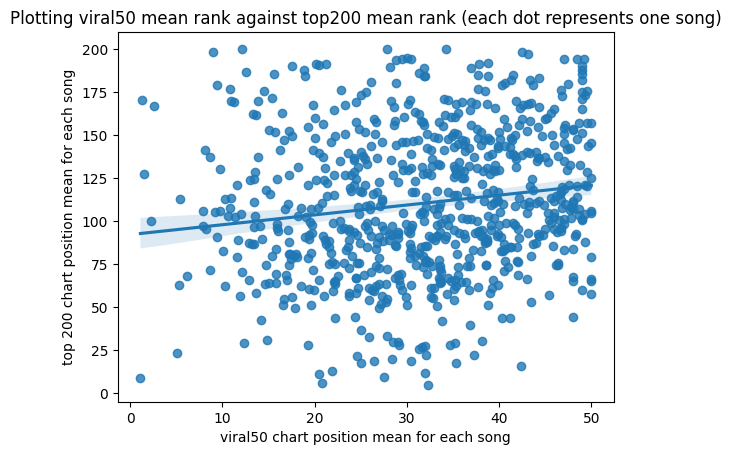

In [204]:
sns.regplot(data=rank_title_df, x = "viral_50_rank_mean", y = "top_200_rank_mean")
plt.title("Plotting viral50 mean rank against top200 mean rank (each dot represents one song)")
plt.xlabel("viral50 chart position mean for each song")
plt.ylabel("top 200 chart position mean for each song")
plt.show()

In [203]:
rank_title_df.corr(method="pearson")

/tmp/ipykernel_18697/3681865541.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rank_title_df.corr(method="pearson")


,viral_50_rank_mean,top_200_rank_mean
viral_50_rank_mean,1.000000,0.152003
top_200_rank_mean,0.152003,1.000000


As we can see, the viral50 and top 200 ranks are only very weakly correlated. This forces us to reconsider our plan of action, since we wanted to use the viral 50 position to predict the rank in the top 200 charts.